In [93]:
import numpy as np
import random
from collections import defaultdict


In [94]:
# Load words safely
with open("corpus.txt", "r") as f:
    words = [w.strip().lower() for w in f if w.strip()]

# Basic cleanup: remove very short words
words = [w for w in words if len(w) >= 3 and len(w) <= 15]

# Shuffle and split (80/20)
random.seed(42)
random.shuffle(words)
split_idx = int(0.8 * len(words))
train_words = words[:split_idx]
test_words = words[split_idx:]

print(f"Train size: {len(train_words)}, Test size: {len(test_words)}")
print("Example words:", train_words[:5])


Train size: 38773, Test size: 9694
Example words: ['undeclining', 'carbromal', 'arsinic', 'togata', 'upanishadic']


In [95]:
alphabet = [chr(i) for i in range(ord('a'), ord('z') + 1)]


In [96]:
bigram_counts = defaultdict(lambda: defaultdict(int))
trigram_counts = defaultdict(lambda: defaultdict(int))
state_counts_2 = defaultdict(int)
state_counts_3 = defaultdict(int)

for word in train_words:
    word = "<s><s>" + word + "</s>"
    # bigram counts
    for i in range(1, len(word)):
        prev = word[i-1]
        curr = word[i]
        bigram_counts[prev][curr] += 1
        state_counts_2[prev] += 1
    # trigram counts
    for i in range(2, len(word)):
        prev2 = word[i-2:i]
        curr = word[i]
        trigram_counts[prev2][curr] += 1
        state_counts_3[prev2] += 1


In [97]:
alpha = 0.01  # smoothing factor
bigram_probs = defaultdict(dict)
trigram_probs = defaultdict(dict)

# bigram probabilities
for s in bigram_counts:
    total = sum(bigram_counts[s].values()) + alpha * len(alphabet)
    for l in alphabet:
        bigram_probs[s][l] = (bigram_counts[s][l] + alpha) / total

# trigram probabilities
for s in trigram_counts:
    total = sum(trigram_counts[s].values()) + alpha * len(alphabet)
    for l in alphabet:
        trigram_probs[s][l] = (trigram_counts[s][l] + alpha) / total


In [98]:
def predict_letter_probabilities(context, lambda3=0.7, lambda2=0.3):
    """
    Return probability distribution over next letters
    blending trigram and bigram probabilities.
    """
    # last two letters for trigram
    trigram_ctx = context[-2:] if len(context) >= 2 else "<s>" + context
    trigram_dist = trigram_probs.get(trigram_ctx, {})

    # last one letter for bigram
    bigram_ctx = context[-1:] if len(context) >= 1 else "<s>"
    bigram_dist = bigram_probs.get(bigram_ctx, {})

    probs = {}
    for l in alphabet:
        p3 = trigram_dist.get(l, 1e-8)
        p2 = bigram_dist.get(l, 1e-8)
        probs[l] = lambda3 * p3 + lambda2 * p2
    return probs


In [99]:
# Cell 1: Hangman Environment
class HangmanEnvironment:
    """
    Hangman game environment for RL agent
    """
    def __init__(self, word):
        self.word = word.lower()
        self.word_length = len(self.word)
        self.max_wrong_guesses = 6
        self.reset()

    def reset(self):
        """Reset the game state"""
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.masked_word = ['_'] * self.word_length
        self.game_over = False
        self.won = False
        return self.get_state()

    def get_state(self):
        """Return current state representation"""
        return {
            'masked_word': ''.join(self.masked_word),
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong_guesses - self.wrong_guesses,
            'game_over': self.game_over,
            'won': self.won
        }

    def step(self, letter):
        """
        Take an action (guess a letter) and return:
        - next_state
        - reward
        - done flag
        - info dict
        """
        letter = letter.lower()

        # Check for repeated guess
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -5  # Heavy penalty for repeated guess
            return self.get_state(), reward, self.game_over, {'repeated': True}

        # Add to guessed letters
        self.guessed_letters.add(letter)

        # Check if letter is in word
        if letter in self.word:
            # Correct guess - reveal all occurrences
            reward = 0
            occurrences = 0
            for i, char in enumerate(self.word):
                if char == letter:
                    self.masked_word[i] = letter
                    occurrences += 1

            reward = occurrences * 2  # Reward based on how many positions revealed

            # Check if word is complete
            if '_' not in self.masked_word:
                self.won = True
                self.game_over = True
                reward += 50  # Big bonus for winning
        else:
            # Wrong guess
            self.wrong_guesses += 1
            reward = -10  # Penalty for wrong guess

            # Check if game over (out of lives)
            if self.wrong_guesses >= self.max_wrong_guesses:
                self.game_over = True
                reward = -50  # Big penalty for losing

        return self.get_state(), reward, self.game_over, {'repeated': False}

    def get_available_actions(self):
        """Return list of letters that haven't been guessed yet"""
        return [l for l in alphabet if l not in self.guessed_letters]

# Test the environment
test_env = HangmanEnvironment("apple")
state = test_env.reset()
print("Initial state:", state)

next_state, reward, done, info = test_env.step('a')
print(f"\nGuess 'a': Reward={reward}, State={next_state['masked_word']}")

next_state, reward, done, info = test_env.step('p')
print(f"Guess 'p': Reward={reward}, State={next_state['masked_word']}")

next_state, reward, done, info = test_env.step('x')
print(f"Guess 'x': Reward={reward}, State={next_state['masked_word']}, Lives={next_state['lives_left']}")

Initial state: {'masked_word': '_____', 'guessed_letters': set(), 'wrong_guesses': 0, 'lives_left': 6, 'game_over': False, 'won': False}

Guess 'a': Reward=2, State=a____
Guess 'p': Reward=4, State=app__
Guess 'x': Reward=-10, State=app__, Lives=5


In [100]:
# Cell 2: State Encoding for Q-Table
def encode_state(state):
    """
    Encode the game state into a hashable string for Q-table lookup
    Format: "masked_word:guessed_letters:lives_left"
    """
    masked = state['masked_word']
    guessed = ''.join(sorted(state['guessed_letters']))
    lives = str(state['lives_left'])

    # Create compact representation
    state_str = f"{masked}:{guessed}:{lives}"
    return state_str

# Test state encoding
test_state = {
    'masked_word': '_pp__',
    'guessed_letters': {'a', 'p', 'x'},
    'wrong_guesses': 1,
    'lives_left': 5,
    'game_over': False,
    'won': False
}

encoded = encode_state(test_state)
print("Encoded state:", encoded)
print("Length:", len(encoded))

Encoded state: _pp__:apx:5
Length: 11


In [101]:
# Cell 3: Q-Learning Agent
class QLearningAgent:
    """
    Q-Learning agent that uses HMM probabilities to guide letter selection
    """
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Args:
            alpha: Learning rate
            gamma: Discount factor
            epsilon: Initial exploration rate
            epsilon_decay: Rate at which epsilon decreases
            epsilon_min: Minimum epsilon value
        """
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def get_hmm_probabilities(self, state):
        """
        Get letter probabilities from HMM based on current masked word
        """
        masked_word = state['masked_word']
        guessed = state['guessed_letters']

        # Get probability for each blank position
        letter_scores = defaultdict(float)

        blank_positions = [i for i, c in enumerate(masked_word) if c == '_']

        if not blank_positions:
            return {}

        # For each blank position, get context and predict probabilities
        for pos in blank_positions:
            # Get context (previous revealed letters)
            context = ""
            # Look back up to 2 characters for trigram context
            for j in range(max(0, pos-2), pos):
                if masked_word[j] != '_':
                    context += masked_word[j]

            # If no context at start, use special start tokens
            if pos == 0 or pos == 1:
                context = "<s>" * (2 - len(context)) + context

            # Get probabilities from HMM
            probs = predict_letter_probabilities(context)

            # Accumulate scores for each letter
            for letter, prob in probs.items():
                if letter not in guessed:
                    letter_scores[letter] += prob

        # Normalize scores
        total = sum(letter_scores.values())
        if total > 0:
            letter_scores = {k: v/total for k, v in letter_scores.items()}

        return letter_scores

    def choose_action(self, state, env):
        """
        Choose action using epsilon-greedy policy with HMM guidance
        """
        available_actions = env.get_available_actions()

        if not available_actions:
            return None

        state_str = encode_state(state)

        # Epsilon-greedy exploration
        if random.random() < self.epsilon:
            # Explore: use HMM probabilities to guide exploration
            hmm_probs = self.get_hmm_probabilities(state)

            if hmm_probs:
                # Sample based on HMM probabilities
                letters = list(hmm_probs.keys())
                probs = list(hmm_probs.values())

                # Filter to available actions only
                available_hmm = [(l, p) for l, p in zip(letters, probs) if l in available_actions]

                if available_hmm:
                    letters, probs = zip(*available_hmm)
                    # Normalize
                    total = sum(probs)
                    probs = [p/total for p in probs]
                    return np.random.choice(letters, p=probs)

            # Fallback to random
            return random.choice(available_actions)
        else:
            # Exploit: choose action with highest Q-value
            # Combine Q-values with HMM probabilities
            hmm_probs = self.get_hmm_probabilities(state)

            best_action = None
            best_value = float('-inf')

            for action in available_actions:
                q_value = self.q_table[state_str][action]
                hmm_bonus = hmm_probs.get(action, 0) * 10  # Scale HMM influence
                combined_value = q_value + hmm_bonus

                if combined_value > best_value:
                    best_value = combined_value
                    best_action = action

            return best_action if best_action else random.choice(available_actions)

    def update(self, state, action, reward, next_state, done):
        """
        Update Q-value using Q-learning update rule
        """
        state_str = encode_state(state)
        next_state_str = encode_state(next_state)

        # Current Q-value
        current_q = self.q_table[state_str][action]

        # Maximum Q-value for next state
        if done:
            max_next_q = 0
        else:
            next_q_values = self.q_table[next_state_str]
            max_next_q = max(next_q_values.values()) if next_q_values else 0

        # Q-learning update
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_str][action] = new_q

    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Initialize agent
agent = QLearningAgent(alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)
print("Q-Learning Agent initialized")
print(f"Initial epsilon: {agent.epsilon}")

Q-Learning Agent initialized
Initial epsilon: 1.0


In [102]:
# Cell 4: Training Loop
import matplotlib.pyplot as plt

def train_agent(agent, train_words, num_episodes=5000, verbose_every=500):
    """
    Train the Q-learning agent on training words
    """
    # Metrics tracking
    episode_rewards = []
    episode_wins = []
    episode_wrong_guesses = []
    episode_repeated_guesses = []
    win_rate_history = []

    for episode in range(num_episodes):
        # Select random word
        word = random.choice(train_words)
        env = HangmanEnvironment(word)

        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False

        # Play episode
        while not done:
            # Choose action
            action = agent.choose_action(state, env)

            if action is None:  # No available actions
                break

            # Take action
            next_state, reward, done, info = env.step(action)

            # Update Q-table
            agent.update(state, action, reward, next_state, done)

            # Update state and reward
            state = next_state
            total_reward += reward

        # Decay epsilon
        agent.decay_epsilon()

        # Record metrics
        episode_rewards.append(total_reward)
        episode_wins.append(1 if env.won else 0)
        episode_wrong_guesses.append(env.wrong_guesses)
        episode_repeated_guesses.append(env.repeated_guesses)

        # Calculate rolling win rate (last 100 episodes)
        if episode >= 99:
            recent_wins = sum(episode_wins[-100:])
            win_rate_history.append(recent_wins / 100)

        # Verbose output
        if (episode + 1) % verbose_every == 0:
            recent_wins = sum(episode_wins[-verbose_every:])
            win_rate = recent_wins / verbose_every
            avg_reward = np.mean(episode_rewards[-verbose_every:])
            avg_wrong = np.mean(episode_wrong_guesses[-verbose_every:])
            avg_repeated = np.mean(episode_repeated_guesses[-verbose_every:])

            print(f"Episode {episode + 1}/{num_episodes}")
            print(f"  Win Rate: {win_rate:.2%}")
            print(f"  Avg Reward: {avg_reward:.2f}")
            print(f"  Avg Wrong Guesses: {avg_wrong:.2f}")
            print(f"  Avg Repeated Guesses: {avg_repeated:.2f}")
            print(f"  Epsilon: {agent.epsilon:.4f}")
            print()

    return {
        'episode_rewards': episode_rewards,
        'episode_wins': episode_wins,
        'episode_wrong_guesses': episode_wrong_guesses,
        'episode_repeated_guesses': episode_repeated_guesses,
        'win_rate_history': win_rate_history
    }

# Train the agent
print("Starting training...")
print(f"Training on {len(train_words)} words for 5000 episodes\n")

training_results = train_agent(agent, train_words, num_episodes=5000, verbose_every=500)

print("\n" + "="*50)
print("Training Complete!")
print("="*50)

Starting training...
Training on 38773 words for 5000 episodes

Episode 500/5000
  Win Rate: 19.60%
  Avg Reward: -65.65
  Avg Wrong Guesses: 5.61
  Avg Repeated Guesses: 0.00
  Epsilon: 0.0816

Episode 1000/5000
  Win Rate: 29.20%
  Avg Reward: -53.07
  Avg Wrong Guesses: 5.36
  Avg Repeated Guesses: 0.00
  Epsilon: 0.0100

Episode 1500/5000
  Win Rate: 26.60%
  Avg Reward: -55.93
  Avg Wrong Guesses: 5.40
  Avg Repeated Guesses: 0.00
  Epsilon: 0.0100

Episode 2000/5000
  Win Rate: 26.80%
  Avg Reward: -55.55
  Avg Wrong Guesses: 5.42
  Avg Repeated Guesses: 0.00
  Epsilon: 0.0100

Episode 2500/5000
  Win Rate: 25.80%
  Avg Reward: -56.53
  Avg Wrong Guesses: 5.38
  Avg Repeated Guesses: 0.00
  Epsilon: 0.0100

Episode 3000/5000
  Win Rate: 25.80%
  Avg Reward: -57.60
  Avg Wrong Guesses: 5.47
  Avg Repeated Guesses: 0.00
  Epsilon: 0.0100

Episode 3500/5000
  Win Rate: 29.20%
  Avg Reward: -52.45
  Avg Wrong Guesses: 5.36
  Avg Repeated Guesses: 0.00
  Epsilon: 0.0100

Episode 4000/

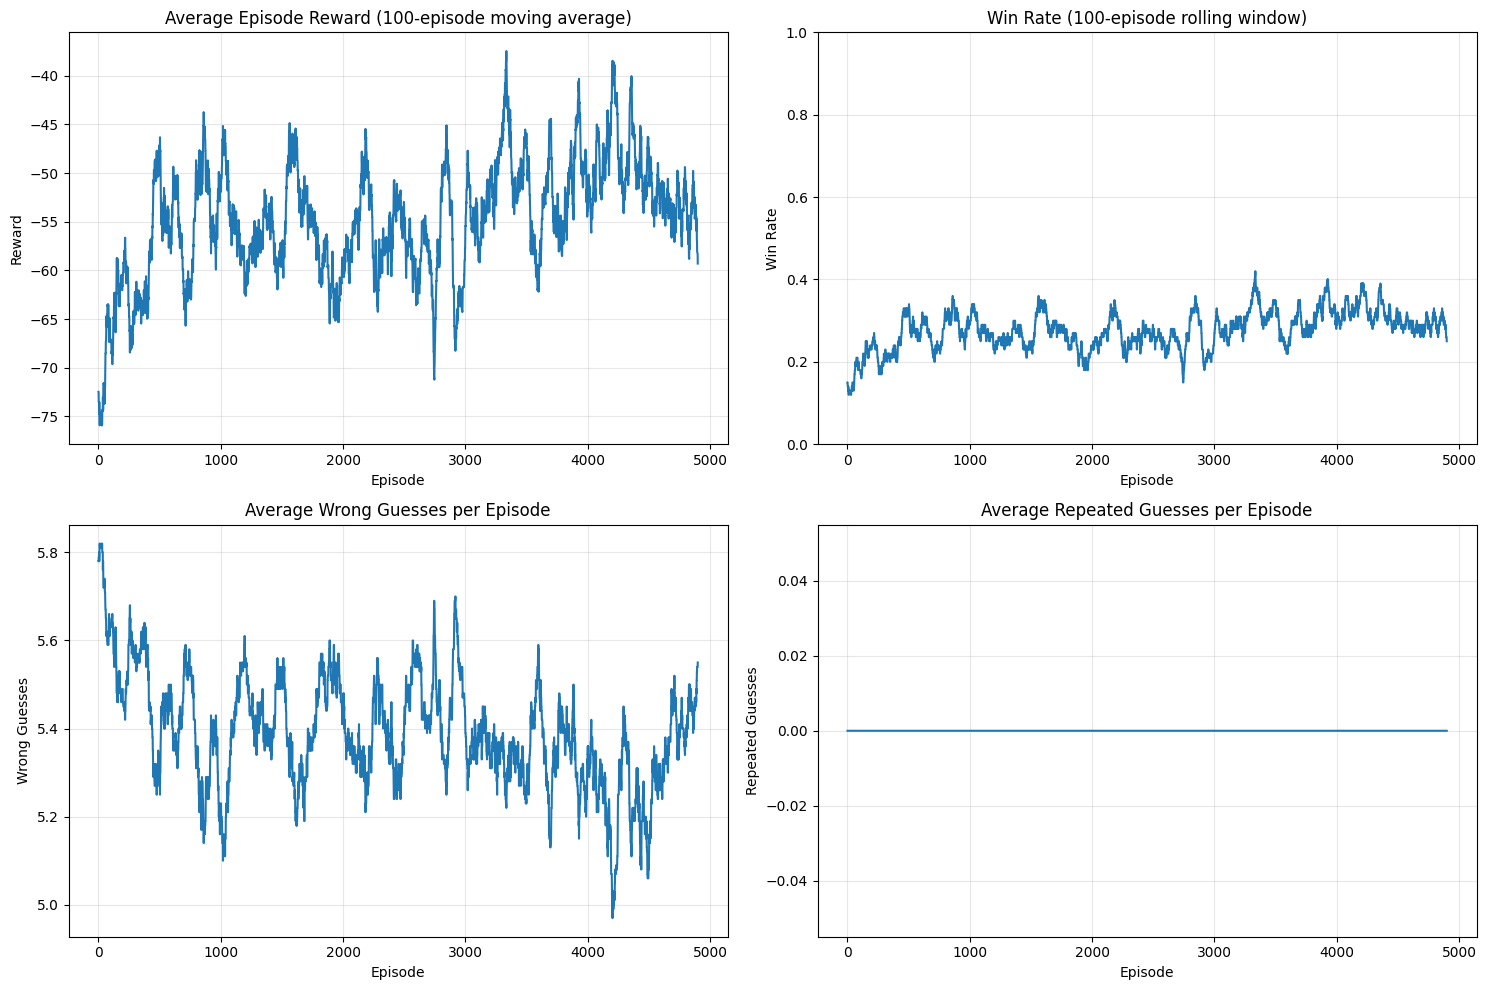


Final Training Statistics (last 500 episodes):
Win Rate: 29.20%
Avg Reward: -52.86
Avg Wrong Guesses: 5.35
Avg Repeated Guesses: 0.00


In [103]:
# Cell 5: Visualize Training Results
def plot_training_results(results):
    """
    Plot training metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Episode Rewards (smoothed)
    window = 100
    smoothed_rewards = np.convolve(results['episode_rewards'],
                                   np.ones(window)/window, mode='valid')
    axes[0, 0].plot(smoothed_rewards)
    axes[0, 0].set_title('Average Episode Reward (100-episode moving average)')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Win Rate
    axes[0, 1].plot(results['win_rate_history'])
    axes[0, 1].set_title('Win Rate (100-episode rolling window)')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Win Rate')
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Wrong Guesses (smoothed)
    smoothed_wrong = np.convolve(results['episode_wrong_guesses'],
                                np.ones(window)/window, mode='valid')
    axes[1, 0].plot(smoothed_wrong)
    axes[1, 0].set_title('Average Wrong Guesses per Episode')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Wrong Guesses')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Repeated Guesses (smoothed)
    smoothed_repeated = np.convolve(results['episode_repeated_guesses'],
                                   np.ones(window)/window, mode='valid')
    axes[1, 1].plot(smoothed_repeated)
    axes[1, 1].set_title('Average Repeated Guesses per Episode')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Repeated Guesses')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final statistics
    print("\nFinal Training Statistics (last 500 episodes):")
    print(f"Win Rate: {np.mean(results['episode_wins'][-500:]):.2%}")
    print(f"Avg Reward: {np.mean(results['episode_rewards'][-500:]):.2f}")
    print(f"Avg Wrong Guesses: {np.mean(results['episode_wrong_guesses'][-500:]):.2f}")
    print(f"Avg Repeated Guesses: {np.mean(results['episode_repeated_guesses'][-500:]):.2f}")

# Plot results
plot_training_results(training_results)

In [104]:
# Cell 6: Evaluate on Test Set
def evaluate_agent(agent, test_words, num_games=2000):
    """
    Evaluate trained agent on test set
    """
    wins = 0
    total_wrong_guesses = 0
    total_repeated_guesses = 0

    game_details = []

    # Temporarily set epsilon to 0 for pure exploitation
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    for i, word in enumerate(test_words[:num_games]):
        env = HangmanEnvironment(word)
        state = env.reset()
        done = False

        while not done:
            action = agent.choose_action(state, env)

            if action is None:
                break

            next_state, reward, done, info = env.step(action)
            state = next_state

        # Record results
        if env.won:
            wins += 1

        total_wrong_guesses += env.wrong_guesses
        total_repeated_guesses += env.repeated_guesses

        game_details.append({
            'word': word,
            'won': env.won,
            'wrong_guesses': env.wrong_guesses,
            'repeated_guesses': env.repeated_guesses,
            'total_guesses': len(env.guessed_letters)
        })

        if (i + 1) % 500 == 0:
            print(f"Evaluated {i + 1}/{num_games} games...")

    # Restore epsilon
    agent.epsilon = original_epsilon

    # Calculate metrics
    success_rate = wins / num_games
    avg_wrong_guesses = total_wrong_guesses / num_games
    avg_repeated_guesses = total_repeated_guesses / num_games

    # Calculate final score according to problem statement
    final_score = (success_rate * num_games) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)

    results = {
        'num_games': num_games,
        'wins': wins,
        'success_rate': success_rate,
        'total_wrong_guesses': total_wrong_guesses,
        'avg_wrong_guesses': avg_wrong_guesses,
        'total_repeated_guesses': total_repeated_guesses,
        'avg_repeated_guesses': avg_repeated_guesses,
        'final_score': final_score,
        'game_details': game_details
    }

    return results

# Evaluate on test set
print("Evaluating agent on test set...")
print(f"Running {len(test_words)} games...\n")

test_results = evaluate_agent(agent, test_words, num_games=len(test_words))

# Print results
print("\n" + "="*60)
print("TEST SET EVALUATION RESULTS")
print("="*60)
print(f"Total Games: {test_results['num_games']}")
print(f"Wins: {test_results['wins']}")
print(f"Success Rate: {test_results['success_rate']:.2%}")
print(f"\nTotal Wrong Guesses: {test_results['total_wrong_guesses']}")
print(f"Average Wrong Guesses per Game: {test_results['avg_wrong_guesses']:.2f}")
print(f"\nTotal Repeated Guesses: {test_results['total_repeated_guesses']}")
print(f"Average Repeated Guesses per Game: {test_results['avg_repeated_guesses']:.2f}")
print(f"\n{'='*60}")
print(f"FINAL SCORE: {test_results['final_score']:.2f}")
print(f"{'='*60}")

Evaluating agent on test set...
Running 9694 games...

Evaluated 500/9694 games...
Evaluated 1000/9694 games...
Evaluated 1500/9694 games...
Evaluated 2000/9694 games...
Evaluated 2500/9694 games...
Evaluated 3000/9694 games...
Evaluated 3500/9694 games...
Evaluated 4000/9694 games...
Evaluated 4500/9694 games...
Evaluated 5000/9694 games...
Evaluated 5500/9694 games...
Evaluated 6000/9694 games...
Evaluated 6500/9694 games...
Evaluated 7000/9694 games...
Evaluated 7500/9694 games...
Evaluated 8000/9694 games...
Evaluated 8500/9694 games...
Evaluated 9000/9694 games...
Evaluated 9500/9694 games...

TEST SET EVALUATION RESULTS
Total Games: 9694
Wins: 2651
Success Rate: 27.35%

Total Wrong Guesses: 52190
Average Wrong Guesses per Game: 5.38

Total Repeated Guesses: 0
Average Repeated Guesses per Game: 0.00

FINAL SCORE: -258299.00



Detailed Analysis:
------------------------------------------------------------

Performance by Word Length:
  Length  3:   65 words, Win Rate:  4.6%, Avg Wrong: 5.86
  Length  4:  213 words, Win Rate: 13.6%, Avg Wrong: 5.76
  Length  5:  477 words, Win Rate: 13.4%, Avg Wrong: 5.71
  Length  6:  764 words, Win Rate: 11.1%, Avg Wrong: 5.78
  Length  7: 1014 words, Win Rate: 15.1%, Avg Wrong: 5.68
  Length  8: 1302 words, Win Rate: 17.1%, Avg Wrong: 5.63
  Length  9: 1386 words, Win Rate: 23.7%, Avg Wrong: 5.49
  Length 10: 1325 words, Win Rate: 29.7%, Avg Wrong: 5.33
  Length 11: 1113 words, Win Rate: 36.8%, Avg Wrong: 5.20
  Length 12:  787 words, Win Rate: 37.9%, Avg Wrong: 5.12
  Length 13:  600 words, Win Rate: 52.3%, Avg Wrong: 4.72
  Length 14:  413 words, Win Rate: 55.0%, Avg Wrong: 4.65
  Length 15:  235 words, Win Rate: 52.8%, Avg Wrong: 4.72


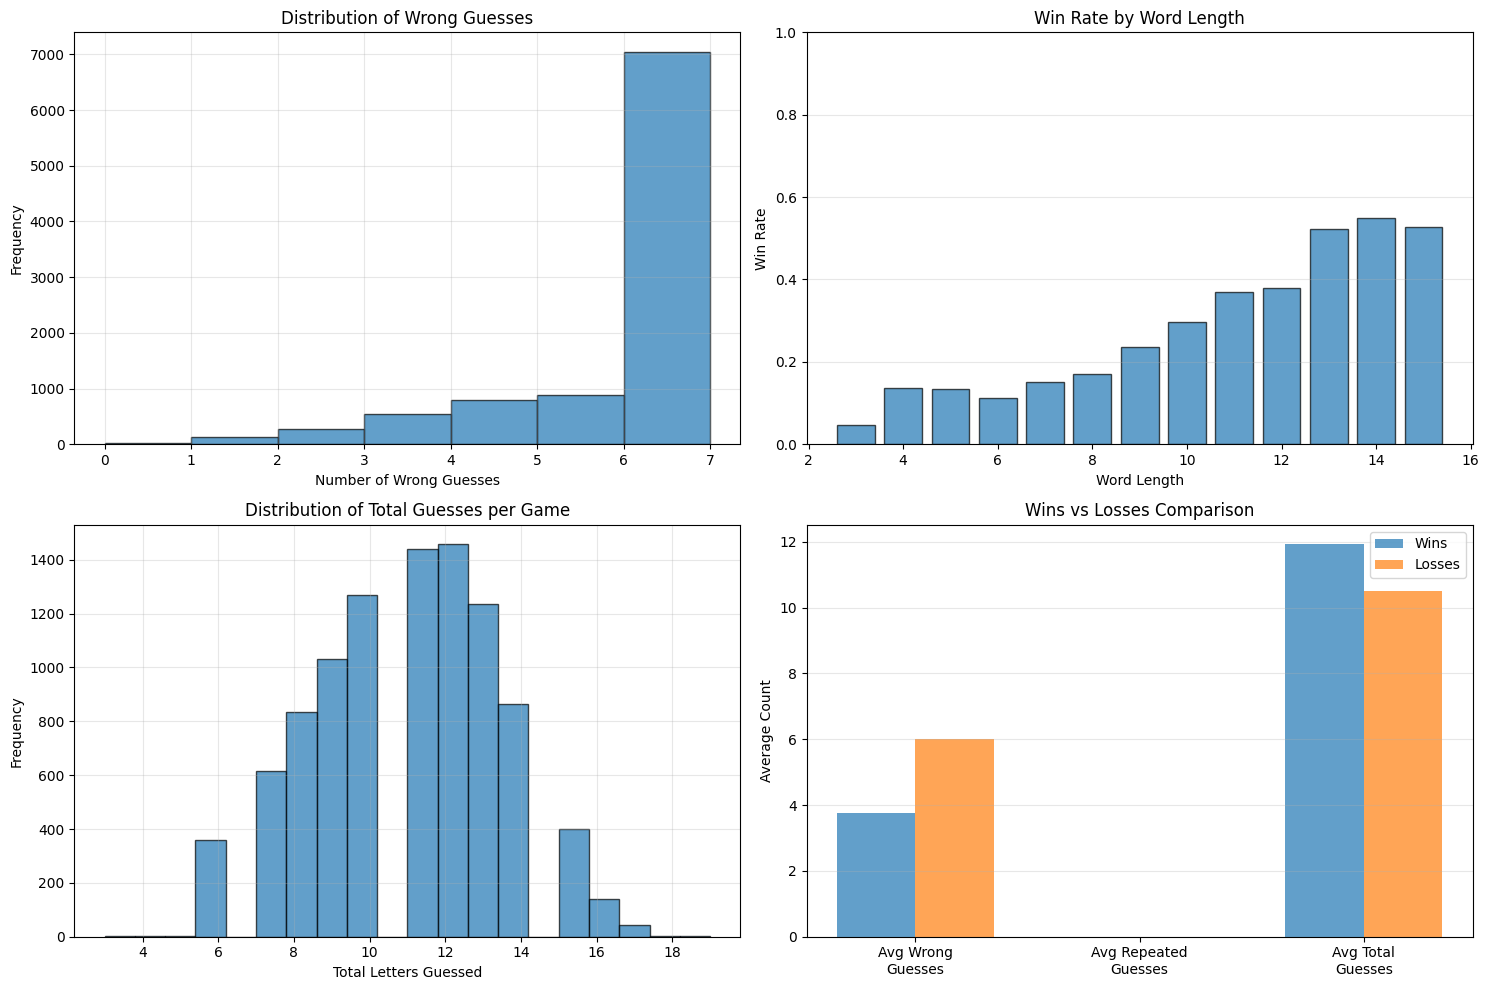


Example Successful Games:
1. Word: 'scutellaria' - Wrong: 2, Repeated: 0, Total: 11
2. Word: 'supercongestion' - Wrong: 2, Repeated: 0, Total: 13
3. Word: 'trame' - Wrong: 5, Repeated: 0, Total: 10
4. Word: 'papermouth' - Wrong: 5, Repeated: 0, Total: 14
5. Word: 'recondensation' - Wrong: 1, Repeated: 0, Total: 11

Example Failed Games:
1. Word: 'psychoda' - Wrong: 6, Repeated: 0, Total: 9
2. Word: 'dejectory' - Wrong: 6, Repeated: 0, Total: 11
3. Word: 'yabu' - Wrong: 6, Repeated: 0, Total: 7
4. Word: 'genuinely' - Wrong: 6, Repeated: 0, Total: 10
5. Word: 'foresend' - Wrong: 6, Repeated: 0, Total: 10


In [105]:
# Cell 7: Detailed Analysis and Visualization
def analyze_test_results(results):
    """
    Perform detailed analysis of test results
    """
    game_details = results['game_details']

    # Separate wins and losses
    wins = [g for g in game_details if g['won']]
    losses = [g for g in game_details if not g['won']]

    print("\nDetailed Analysis:")
    print("-" * 60)

    # Word length analysis
    word_lengths = defaultdict(lambda: {'total': 0, 'wins': 0, 'wrong': 0})
    for game in game_details:
        length = len(game['word'])
        word_lengths[length]['total'] += 1
        if game['won']:
            word_lengths[length]['wins'] += 1
        word_lengths[length]['wrong'] += game['wrong_guesses']

    print("\nPerformance by Word Length:")
    for length in sorted(word_lengths.keys()):
        stats = word_lengths[length]
        win_rate = stats['wins'] / stats['total'] if stats['total'] > 0 else 0
        avg_wrong = stats['wrong'] / stats['total'] if stats['total'] > 0 else 0
        print(f"  Length {length:2d}: {stats['total']:4d} words, "
              f"Win Rate: {win_rate:5.1%}, Avg Wrong: {avg_wrong:.2f}")

    # Distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Wrong guesses distribution
    all_wrong = [g['wrong_guesses'] for g in game_details]
    axes[0, 0].hist(all_wrong, bins=range(0, 8), edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribution of Wrong Guesses')
    axes[0, 0].set_xlabel('Number of Wrong Guesses')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Win rate by word length
    lengths = sorted(word_lengths.keys())
    win_rates = [word_lengths[l]['wins'] / word_lengths[l]['total'] for l in lengths]
    axes[0, 1].bar(lengths, win_rates, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Win Rate by Word Length')
    axes[0, 1].set_xlabel('Word Length')
    axes[0, 1].set_ylabel('Win Rate')
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Plot 3: Total guesses distribution
    total_guesses = [g['total_guesses'] for g in game_details]
    axes[1, 0].hist(total_guesses, bins=20, edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('Distribution of Total Guesses per Game')
    axes[1, 0].set_xlabel('Total Letters Guessed')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Comparison of wins vs losses
    categories = ['Avg Wrong\nGuesses', 'Avg Repeated\nGuesses', 'Avg Total\nGuesses']

    if wins and losses:
        wins_stats = [
            np.mean([g['wrong_guesses'] for g in wins]),
            np.mean([g['repeated_guesses'] for g in wins]),
            np.mean([g['total_guesses'] for g in wins])
        ]
        losses_stats = [
            np.mean([g['wrong_guesses'] for g in losses]),
            np.mean([g['repeated_guesses'] for g in losses]),
            np.mean([g['total_guesses'] for g in losses])
        ]

        x = np.arange(len(categories))
        width = 0.35

        axes[1, 1].bar(x - width/2, wins_stats, width, label='Wins', alpha=0.7)
        axes[1, 1].bar(x + width/2, losses_stats, width, label='Losses', alpha=0.7)
        axes[1, 1].set_title('Wins vs Losses Comparison')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(categories)
        axes[1, 1].set_ylabel('Average Count')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Show some example games
    print("\n" + "="*60)
    print("Example Successful Games:")
    print("="*60)
    for i, game in enumerate(wins[:5]):
        print(f"{i+1}. Word: '{game['word']}' - Wrong: {game['wrong_guesses']}, "
              f"Repeated: {game['repeated_guesses']}, Total: {game['total_guesses']}")

    print("\n" + "="*60)
    print("Example Failed Games:")
    print("="*60)
    for i, game in enumerate(losses[:5]):
        print(f"{i+1}. Word: '{game['word']}' - Wrong: {game['wrong_guesses']}, "
              f"Repeated: {game['repeated_guesses']}, Total: {game['total_guesses']}")

# Run detailed analysis
analyze_test_results(test_results)